In [15]:
push!(LOAD_PATH, pwd()*"/../src")

using SeisAcoustic, SeisPlot
using forward: single_source_forward
using gradient: conventional_gradient
using backward: reduced_wavefield_imaging
using utils: MultiSeisPlotTX, readFile!

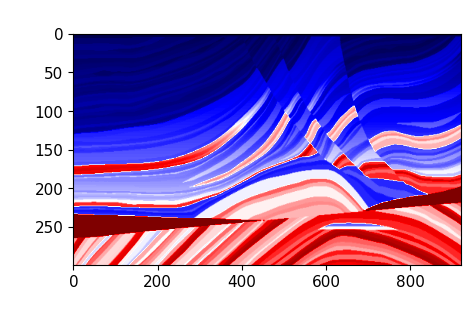

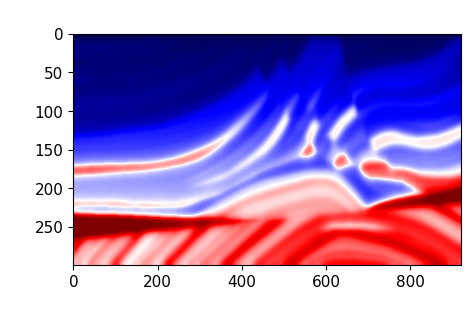

In [16]:
data_format = Float32

# model dimensions
shape   = (300, 920) # nz, nx
spacing = (10, 10)

# velocity and density models
vel = zeros(data_format, shape[1]*shape[2]);  # m/s
readFile!("../data/marmousi_nz300_nx920.bin", vel)
vel = reshape(vel, (shape[1],shape[2]))

rho = 1500f0*ones(data_format, shape);  

# smooth velocity
vel0 = zeros(data_format, shape[1]*shape[2]);  # m/s
readFile!("../data/marmousi_suave_nz300_nx920.bin", vel0)
vel0 = reshape(vel0, (shape[1],shape[2]));

# Plot
SeisPlotTX(vel, cmap="seismic", hbox=3,wbox=5, vmin=1500, vmax=5000);
SeisPlotTX(vel0, cmap="seismic", hbox=3,wbox=5, vmin=1500, vmax=5000);


In [17]:
# aquisition and other SeisAcoustic parameters for FD calculation
free_surface = false
dt = 0.0005
tmax = 4
order = 2
npml = 20;
fd_flag = "taylor"

# set SeisAcoustic required structure parameters
# True model
params = TdParams(rho, vel, free_surface, spacing[1], spacing[2], dt, tmax;
                  fd_flag=fd_flag, data_format=data_format, order=order, npml=npml);
# Smooth model
params0= TdParams(rho, vel0, free_surface, spacing[1], spacing[2], dt, tmax;
                  fd_flag=fd_flag, data_format=data_format, order=order, npml=npml);
       

In [18]:
# Source and receivers information

# initialize a source
isz = 10; isx = 460;
src = Source(isz, isx, params; amp=rho[isz,isx]*vel0[isz,isx]*vel0[isz,isx], fdom=10, type_flag="ricker")

# generate observed data
irx = collect(1:2:shape[2]);
irz = 10*ones(Int64, length(irx));

In [19]:
# Observed data
rec, _ = single_source_forward(src, params; rz=irz, rx=irx);

# auxiliary files to store: the fields at the boundary and the last wavefield. 
# They will be used to reconstruct the source field.
path_bnd = joinpath(pwd(), "./bnd.rsf");
path_lwfd= joinpath(pwd(), "./lwfd.rsf");

# Predicted data
rec0, Gamma_u = single_source_forward(src, params0; rz=irz, rx=irx, 
                                      path_lwfd=path_lwfd, path_bnd=path_bnd);

# Compute residue
res = get_residue(rec, rec0);

# Plot
#SeisPlotTX(rec.p, cmap="gray", hbox=3,wbox=3);
#SeisPlotTX(rec0.p, cmap="gray", hbox=3,wbox=3);
#SeisPlotTX(res.p, cmap="gray", hbox=3,wbox=3);

In [20]:
# Convenctional RTM
g_adj = conventional_gradient(res, path_bnd, path_lwfd, src, params0);

In [21]:
# RWII
alpha = 5e-4
Gamma_w = reduced_wavefield_imaging(res, path_bnd, path_lwfd, src, alpha, params0);

rwii = (Gamma_w-Gamma_u) /(2*alpha);

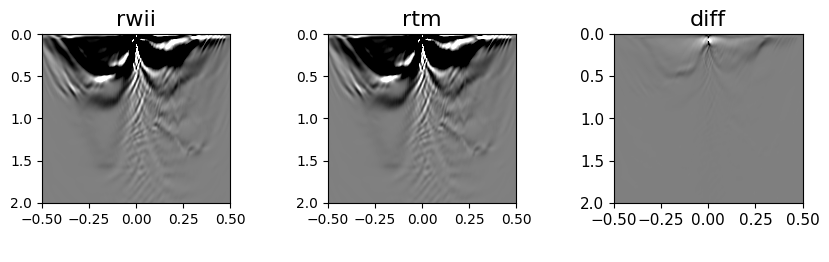

In [23]:
title = ["rwii", "rtm", "diff"]
a = [rwii, reshape(g_adj, shape[1], shape[2]), reshape(g_adj, shape[1], shape[2])-rwii]
MultiSeisPlotTX(a, title=title, cmap="gray", hbox=3, wbox=3, vmin=-1e13, vmax=1e13);